In [66]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
import tensorflow_text as tf_text
from tensorflow.keras.layers.experimental import preprocessing
from typing import Any, Tuple


In [67]:
class ShapeChecker:
    def __init__(self):
        # 保存每个轴名的缓存
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return
        if isinstance(names, str):
            names = (names,)
        shape = tf.shape(tensor)
        rank = tf.rank(tensor)
        if rank != len(names):
            raise ValueError(f'Rank mismatch:\n'
                             f' found {rank}: {shape.numpy()}\n'
                             f' expected {len(names)}: {names}\n')
        for i, name in enumerate(names):
            if isinstance(name, int):
                old_dim = name
            else:
                old_dim = self.shapes.get(name, None)
            new_dim = shape[i]
            if broadcast and new_dim == 1:
                continue
            if old_dim is None:
                # 如果轴名是新的，就把它的长度加到缓存中。
                self.shapes[name] = new_dim
                continue
            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                 f" found: {new_dim}\n"
                                 f" expected: {old_dim}\n")


In [68]:
import pathlib

path_to_file = 'D:\\Users\\Documents\\Schoolwork\\NLP_Homework\\Practice4\\cmn-eng\\cmn.txt'

def load_data(path):
    text = path.read_text(encoding='utf-8')
    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]
    inp = [inp for targ, inp in pairs]
    targ = [targ for targ, inp in pairs]
    return targ, inp


In [69]:
targ, inp = load_data(path_to_file)
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64
#创建一个tf.data.Dataset字符串来有效地对它们进行混洗和批处理：
dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

AttributeError: 'str' object has no attribute 'read_text'

In [19]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5])
    print()
    print(example_target_batch[:5])
    break

tf.Tensor(
[b'Adoro ganar.' b'Es dif\xc3\xadcil entender su teor\xc3\xada.'
 b'Necesito esos documentos.'
 b'Mi mam\xc3\xa1 se levanta temprano por la ma\xc3\xb1ana.'
 b'Hab\xc3\xada huellas de ping\xc3\xbcinos en la arena.'], shape=(5,), dtype=string)

tf.Tensor(
[b'I love winning.' b"It's difficult to understand his theory."
 b'I need those documents.' b'My mother gets up early in the morning.'
 b'There were penguin footprints in the sand.'], shape=(5,), dtype=string)


注意下面这个单元格

In [20]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [21]:
def tf_lower_and_split_punct(text):
    # 对字符进行切分
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # 保持空格，从a到z，并选择标点符号。
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # 在标点符号周围添加空格。
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # 去空格。
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text


In [22]:
print(example_text.numpy().decode())
#输出解码结果(德语)
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


In [23]:
max_vocab_size = 5000
input_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size
)


In [24]:
input_text_processor.adapt(inp)
# 下是词汇表中的前10个单词:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [25]:
output_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size
)
output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [26]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2, 2371,  776,    4,    3,    0,    0,    0,    0,    0],
       [   2,   15,  196,  565,   25, 1698,    4,    3,    0,    0],
       [   2,  148,  574, 2588,    4,    3,    0,    0,    0,    0]],
      dtype=int64)>

In [27]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] adoro ganar . [END]            '

Text(0.5, 1.0, 'Mask')

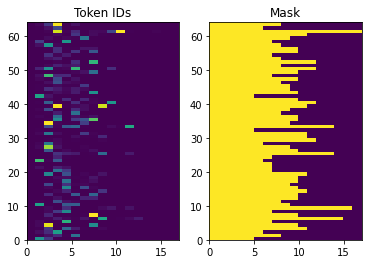

In [28]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')
plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [29]:
#嵌入维度
embedding_dim = 256
#隐藏单元个数
units = 1024

In [30]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size
        # 嵌入层将令牌转换为向量
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size, embedding_dim)
        # GRU RNN层依次处理这些向量。
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, tokens, state=None):
        shape_checker = ShapeChecker()
        shape_checker(tokens, ('batch', 's'))
        # 嵌入层查找每个标记的嵌入情况。
        vectors = self.embedding(tokens)
        shape_checker(vectors, ('batch', 's', 'embed_dim'))
        output, state = self.gru(vectors, initial_state=state)
        shape_checker(output, ('batch', 's', 'enc_units'))
        shape_checker(state, ('batch', 'enc_units'))
        # 返回新的序列和它的状态。
        return output, state


In [31]:
example_tokens = input_text_processor(example_input_batch)
# 对输入序列进行编码。
encoder = Encoder(input_text_processor.vocabulary_size(), embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)
print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')


Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 17)
Encoder output, shape (batch, s, units): (64, 17, 1024)
Encoder state, shape (batch, units): (64, 1024)


In [32]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)
        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
        shape_checker = ShapeChecker()
        shape_checker(query, ('batch', 't', 'query_units'))
        shape_checker(value, ('batch', 's', 'value_units'))
        shape_checker(mask, ('batch', 's'))
        # 构建Query矩阵
        w1_query = self.W1(query)
        shape_checker(w1_query, ('batch', 't', 'attn_units'))
        # 构建Key矩阵
        w2_key = self.W2(value)
        shape_checker(w2_key, ('batch', 's', 'attn_units'))
        # 构建mask矩阵
        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask
        # 计算得到注意力图谱
        context_vector, attention_weights = self.attention(
            inputs=[w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores=True
        )
        shape_checker(context_vector, ('batch', 't', 'value_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))
        return context_vector, attention_weights


In [33]:
attention_layer = BahdanauAttention(units)
# 后续解码器将产生这个attention查询(Query矩阵)
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])
# 添加到编码tokens
context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0)
)
print(f'Attention result shape: (batch_size, query_seq_length, units): {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')


Attention result shape: (batch_size, query_seq_length, units): (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 17)


Text(0.5, 1.0, 'Mask')

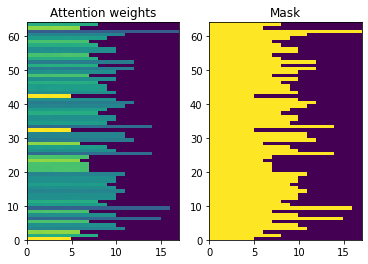

In [34]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')
plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

<Figure size 432x288 with 0 Axes>

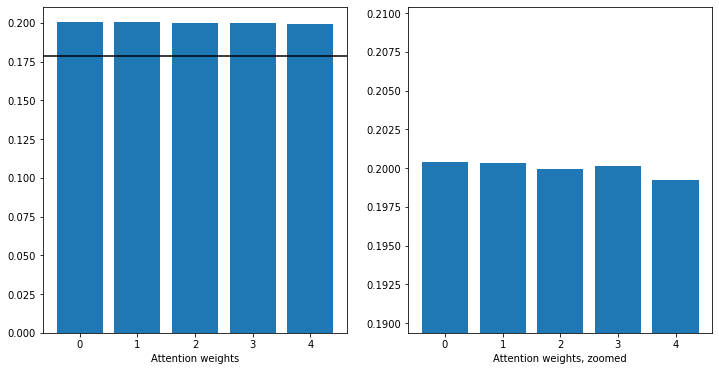

In [35]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]
plt.suptitle('Attention weights for one sequence')
plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# 固定x轴
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')
a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')
# 放大结果
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')
# 输出结果：
# [<matplotlib.lines.Line2D at 0x20c356a9670>]
# <Figure size 432x288 with 0 Axes>


In [36]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim
        # 嵌入层将令牌ID转为向量
        self.embedding = tf.keras.layers.Embedding(self.output_vocab_size, embedding_dim)
        # RNN会记录到目前为止已经生成的内容。
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        # RNN的输出将是注意力层的查询。
        self.attention = BahdanauAttention(self.dec_units)
        self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh, use_bias=False)
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)


In [37]:
import typing

class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any

class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any


In [38]:
def call(self, inputs: DecoderInput, state=None) -> Tuple[DecoderOutput, tf.Tensor]:
    shape_checker = ShapeChecker()
    shape_checker(inputs.new_tokens, ('batch', 't'))
    shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
    shape_checker(inputs.mask, ('batch', 's'))
    if state is not None:
        shape_checker(state, ('batch', 'dec_units'))
    # 查询词嵌入
    vectors = self.embedding(inputs.new_tokens)
    shape_checker(vectors, ('batch', 't', 'embedding_dim'))
    # 用RNN处理一个步骤
    rnn_output, state = self.gru(vectors, initial_state=state)
    shape_checker(rnn_output, ('batch', 't', 'dec_units'))
    shape_checker(state, ('batch', 'dec_units'))
    # 使用RNN输出作为关注的查询，超过了编码器的输出。
    context_vector, attention_weights = self.attention(
        query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
    shape_checker(context_vector, ('batch', 't', 'dec_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))
    # 加入context_vector和rnn_output
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)
    attention_vector = self.Wc(context_and_rnn_output)
    shape_checker(attention_vector, ('batch', 't', 'dec_units'))
    # 生成logit预测
    logits = self.fc(attention_vector)
    shape_checker(logits, ('batch', 't', 'output_vocab_size'))
    return DecoderOutput(logits, attention_weights), state

In [39]:
Decoder.call = call
decoder = Decoder(output_text_processor.vocabulary_size(), embedding_dim, units)

In [40]:
example_output_tokens = output_text_processor(example_target_batch)
start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [41]:
dec_result, dec_state = decoder(
    inputs=DecoderInput(
        new_tokens=first_token,
        enc_output=example_enc_output,
        mask=(example_tokens != 0)
    ),
    state=example_enc_state
)


In [42]:
print(f'logits shape: (batch_size, t, output_vocab_size){dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size)(64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


In [43]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
#将令牌解码为输出的第一个单词。
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['roommate'],
       ['signs'],
       ['hid'],
       ['mp'],
       ['kite']], dtype='<U16')

In [44]:
dec_result, dec_state = decoder(
    DecoderInput(
        sampled_token,
        example_enc_output,
        mask=(example_tokens != 0)
    ),
    state=dec_state
)
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]


array([['still'],
       ['spoke'],
       ['unsure'],
       ['airplane'],
       ['prison']], dtype='<U16')

In [45]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

    def __call__(self, y_true, y_pred):
        shape_checker = ShapeChecker()
        shape_checker(y_true, ('batch', 't'))
        shape_checker(y_pred, ('batch', 't', 'logits'))
        # 计算该批次中每一项的损失。
        loss = self.loss(y_true, y_pred)
        shape_checker(loss, ('batch', 't'))
        mask = tf.cast(y_true != 0, tf.float32)
        shape_checker(mask, ('batch', 't'))
        loss *= mask
        # 返回总的loss。
        return tf.reduce_sum(loss)


In [46]:
class TrainTranslator(tf.keras.Model):
    def __init__(self, embedding_dim, units,
                 input_text_processor,
                 output_text_processor,
                 use_tf_function=True):
        super().__init__()
        # 构建编码器和解码器
        encoder = Encoder(input_text_processor.vocabulary_size(), embedding_dim, units)
        decoder = Decoder(output_text_processor.vocabulary_size(), embedding_dim, units)
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function
        self.shape_checker = ShapeChecker()

    def train_step(self, inputs):
        self.shape_checker = ShapeChecker()
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)


In [47]:
def _preprocess(self, input_text, target_text):
    self.shape_checker(input_text, ('batch',))
    self.shape_checker(target_text, ('batch',))
    # 将文本转换为tokens ID
    input_tokens = self.input_text_processor(input_text)
    target_tokens = self.output_text_processor(target_text)
    self.shape_checker(input_tokens, ('batch', 's'))
    self.shape_checker(target_tokens, ('batch', 't'))
    # 将ID转换为掩码
    input_mask = input_tokens != 0
    self.shape_checker(input_mask, ('batch', 's'))
    target_mask = target_tokens != 0
    self.shape_checker(target_mask, ('batch', 't'))
    return input_tokens, input_mask, target_tokens, target_mask

TrainTranslator._preprocess = _preprocess


In [48]:
def _train_step(self, inputs):
    input_text, target_text = inputs
    (input_tokens, input_mask, target_tokens, target_mask) = self._preprocess(input_text, target_text)
    max_target_length = tf.shape(target_tokens)[1]
    with tf.GradientTape() as tape:
        # 对输入进行编码
        enc_output, enc_state = self.encoder(input_tokens)
        self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
        self.shape_checker(enc_state, ('batch', 'enc_units'))
        # 将解码器的状态初始化为编码器的最终状态。
        # 这只有在编码器和解码器有相同数量的单位时生效。
        dec_state = enc_state
        loss = tf.constant(0.0)
        for t in tf.range(max_target_length-1):
            # 从目标序列中传入两个token:
            # 1. 解码器的当前输入。
            # 2. 解码器下次预测的目标。
            new_tokens = target_tokens[:, t:t+2]
            step_loss, dec_state = self._loop_step(new_tokens, input_mask, enc_output, dec_state)
            loss += step_loss
        # 对所有非填充token的损失进行平均计算。
        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))
        # 设置优化步骤
        variables = self.trainable_variables
        gradients = tape.gradient(average_loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))
        # 返回一个映射到当前值的字典
        return {'batch_loss': average_loss}


In [49]:
TrainTranslator._train_step = _train_step

In [50]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]
    # 运行解码器一步。
    decoder_input = DecoderInput(
        new_tokens=input_token,
        enc_output=enc_output,
        mask=input_mask
    )
    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
    self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
    self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    self.shape_checker(dec_state, ('batch', 'dec_units'))
    # `self.loss`返回非填充token的总数。
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)
    return step_loss, dec_state


In [51]:
TrainTranslator._loop_step = _loop_step
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False
)
# 配置损失和优化器
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)


In [52]:
np.log(output_text_processor.vocabulary_size())

8.517193191416238

In [53]:
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))
    print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.629353>}

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.598426>}

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.543321>}

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.394858>}

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.896864>}

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.082132>}

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.0064697>}

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.268388>}

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1060047>}

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.034461>}

Wall time: 28.7 s


In [54]:
@tf.function(input_signature=[
    [tf.TensorSpec(dtype=tf.string, shape=[None]),
     tf.TensorSpec(dtype=tf.string, shape=[None])]
])
def _tf_train_step(self, inputs):
    return self._train_step(inputs)

TrainTranslator._tf_train_step = _tf_train_step
translator.use_tf_function = True
# 第一次运行由于需要对函数进行追踪，故速度会比较慢
translator.train_step([example_input_batch, example_target_batch])


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.036132>}

In [55]:
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))
    print()


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.008104>}

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9518983>}

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.909128>}

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.816786>}

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.754151>}

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6972537>}

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6535792>}

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5980456>}

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5636666>}

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5353484>}

Wall time: 18.9 s


....................................................................................................


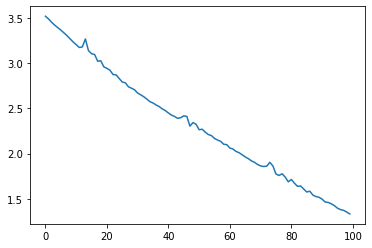

In [56]:
losses = []
for n in range(100):
    print('.', end='')
    logs = translator.train_step([example_input_batch, example_target_batch])
    losses.append(logs['batch_loss'].numpy())
print()
plt.plot(losses)


In [57]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor
)
# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)


In [58]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []

    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')
train_translator.fit(
    dataset, 
    epochs=10,
    steps_per_epoch=10,
    callbacks=[batch_loss]
)


Epoch 1/10
10/10 [==============================] - 29s 2s/step - batch_loss: 6.3380
Epoch 2/10
10/10 [==============================] - 22s 2s/step - batch_loss: 4.8372
Epoch 3/10
10/10 [==============================] - 23s 2s/step - batch_loss: 4.5662
Epoch 4/10
10/10 [==============================] - 23s 2s/step - batch_loss: 4.4185
Epoch 5/10
10/10 [==============================] - 26s 3s/step - batch_loss: 4.3655
Epoch 6/10
10/10 [==============================] - 21s 2s/step - batch_loss: 4.1933
Epoch 7/10
10/10 [==============================] - 23s 2s/step - batch_loss: 4.2153
Epoch 8/10
10/10 [==============================] - 23s 2s/step - batch_loss: 4.1281
Epoch 9/10
10/10 [==============================] - 22s 2s/step - batch_loss: 4.0732
Epoch 10/10
10/10 [==============================] - 26s 3s/step - batch_loss: 4.0672


Text(0, 0.5, 'CE/token')

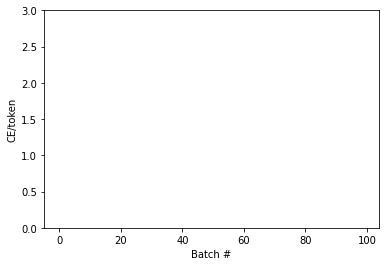

In [59]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [60]:
class Translator(tf.Module):
    def __init__(self, encoder, decoder, input_text_processor, output_text_processor):
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.output_token_string_from_index = (
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=output_text_processor.get_vocabulary(),
                mask_token='',
                invert=True
            )
        )
        # 输出不应该产生padding、unknown或start。
        index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(), mask_token=''
        )
        token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()
        token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=bool)
        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask
        self.start_token = index_from_string(tf.constant('[START]'))
        self.end_token = index_from_string(tf.constant('[END]'))

translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)


In [61]:
def tokens_to_text(self, result_tokens):
    shape_checker = ShapeChecker()
    shape_checker(result_tokens, ('batch', 't'))
    result_text_tokens = self.output_token_string_from_index(result_tokens)
    shape_checker(result_text_tokens, ('batch', 't'))
    result_text = tf.strings.reduce_join(result_text_tokens, axis=1, separator=' ')
    shape_checker(result_text, ('batch'))
    result_text = tf.strings.strip(result_text)
    shape_checker(result_text, ('batch',))
    return result_text

Translator.tokens_to_text = tokens_to_text

example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size()
)
translator.tokens_to_text(example_output_tokens).numpy()


array([b'mosquito screaming', b'speakers bitten', b'tokyo suitcases',
       b'crack burnt', b'society happen'], dtype=object)

In [62]:
def sample(self, logits, temperature):
    shape_checker = ShapeChecker()
    shape_checker(logits, ('batch', 't', 'vocab'))
    shape_checker(self.token_mask, ('vocab',))
    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
    shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)
    logits = tf.where(self.token_mask, -np.inf, logits)
    if temperature == 0.0:
        new_tokens = tf.argmax(logits, axis=-1)
    else:
        logits = tf.squeeze(logits, axis=1)
        new_tokens = tf.random.categorical(logits / temperature, num_samples=1)
    shape_checker(new_tokens, ('batch', 't'))
    return new_tokens

Translator.sample = sample

example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens


<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[3094],
       [4408],
       [4636],
       [1473],
       [1472]], dtype=int64)>

In [63]:
def translate_unrolled(self, input_text, *, max_length=50, return_attention=True, temperature=1.0):
    batch_size = tf.shape(input_text)[0]
    input_tokens = self.input_text_processor(input_text)
    enc_output, enc_state = self.encoder(input_tokens)
    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)
    result_tokens = []
    attention = []
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    for _ in range(max_length):
        dec_input = DecoderInput(
            new_tokens=new_tokens,
            enc_output=enc_output,
            mask=(input_tokens != 0)
        )
        dec_result, dec_state = self.decoder(dec_input, state=dec_state)
        attention.append(dec_result.attention_weights)
        new_tokens = self.sample(dec_result.logits, temperature)
        done = done | (new_tokens == self.end_token)
        # 一旦一个序列完成，它只产生0-padding。
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)
        result_tokens.append(new_tokens)
        if tf.executing_eagerly() and tf.reduce_all(done):
            break
    result_tokens = tf.concat(result_tokens, axis=-1)
    result_text = self.tokens_to_text(result_tokens)
    if return_attention:
        attention_stack = tf.concat(attention, axis=1)
        return {'text': result_text, 'attention': attention_stack}
    else:
        return {'text': result_text}


In [64]:
Translator.translate = translate_unrolled

In [65]:
%%time
input_text = tf.constant([
    'hace mucho frio aqui.',  # "It's really cold here."
    'Esta es mi vida.',       # "This is my life."
])
result = translator.translate(
    input_text=input_text
)
print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

tom shoulders imported true for remembers an capable speaker i whether he be you .
tom bicycle everyone yours pot , insisted .

Wall time: 638 ms
